<h1>
  <img style="padding-bottom: 14px" src="https://monet.postech.ac.kr/~wldh/CNN.png" alt="CNN Logo" />
  <br />
  Convolutional Neural Network (CNN)
</h1>

---

#### Goals

1. Augment(Preprocess) your data
2. Implement a CNN model
3. Learn CIFAR-10 using your CNN model
4. View the features (Active CAM)
5. Understand the overfitting

---

## 1. Library Importation & Device Preparation

In [1]:
# pip install scikit-image
# pip install torchsummary

# You don't need to edit this section today.
import gc
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import torch.nn as nn
import torchvision.transforms as transforms

from IPython.display import clear_output
from skimage.transform import resize as OVResize
from torch.cuda import memory_allocated, empty_cache
from torch.optim import Adam
from torch.utils.data import DataLoader, random_split
from torchsummary import summary as Summary
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, ToTensor, Normalize, RandomCrop, RandomHorizontalFlip, \
                                   ToPILImage, Resize, Grayscale

# nvidia-smi -l 5 : GPU 메모리 확인
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device2 = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(f'{"CPU" if device == "cpu" else "GPU"} will be used in training/validation.')

GPU will be used in training/validation.


## 2. Hyper-parameters

By executing below blocks, you can initialize/update hyper-parameters.

In [2]:
# Data Load
# 밝기 normalize
input_norm_mean = (.4914, .4822, .4465)
input_norm_std = (.2023, .1994, .2010)
batch_size = 16

# Learning
logging_dispfig = True
maximum_epoch = 15
learning_rate = 1e-3

## 3. Data Load & Preprocessing

Today we will use CIFAR-10 dataset with data augmentation.

![CIFAR-10 examples](https://monet.postech.ac.kr/~wldh/CIFAR10.svg)

In [3]:
# Load dataset into python variable
input_transform = transforms.Compose([
    Resize(224),
    RandomCrop(224, padding=24),
    RandomHorizontalFlip(),
    ToTensor(),
    Normalize(mean=input_norm_mean, std=input_norm_std)
])

train_data = CIFAR10("./", train=True, transform=input_transform, download=True)
train_data, valid_data = random_split(train_data, [45000, 5000])
test_data = CIFAR10("./", train=False, transform=input_transform, download=False)

Files already downloaded and verified


Train dataset length = 45000
Valid dataset length = 5000
Test dataset length = 10000

Classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Label (int) = 8 (ship)
Data (Tensor) = torch.Size([3, 224, 224])



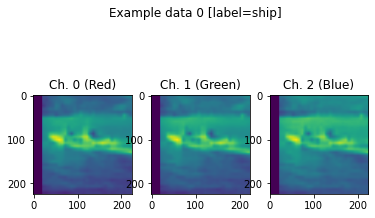

In [18]:
# Check the data
print(f'Train dataset length = {len(train_data)}')
print(f'Valid dataset length = {len(valid_data)}')
print(f'Test dataset length = {len(test_data)}\n')

print(f'Classes = {test_data.classes}\n')

train_0_x, train_0_y = train_data[0]
print(f'Label ({type(train_0_y).__name__}) = {train_0_y} ({test_data.classes[train_0_y]})')
print(f'Data ({type(train_0_x).__name__}) = {train_0_x.shape}\n')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle(f'Example data 0 [label={test_data.classes[train_0_y]}]')
ax1.imshow(train_0_x[0, :, :])
ax1.set_title('Ch. 0 (Red)')
ax2.imshow(train_0_x[1, :, :])
ax2.set_title('Ch. 1 (Green)')
ax3.imshow(train_0_x[2, :, :])
ax3.set_title('Ch. 2 (Blue)')
plt.show()

In [19]:
# Create data loader (same with day 2)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=True,
                          drop_last=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=batch_size, pin_memory=True)

Idx: 0 / X.shape = torch.Size([16, 3, 224, 224]) / Y.shape = torch.Size([16])

Y[0:16] = [7, 6, 9, 7, 6, 6, 0, 1, 9, 6, 4, 6, 7, 5, 5, 1]
→ Label = ['horse' 'frog' 'truck' 'horse' 'frog' 'frog' 'airplane' 'automobile'
 'truck' 'frog' 'deer' 'frog' 'horse' 'dog' 'dog' 'automobile']



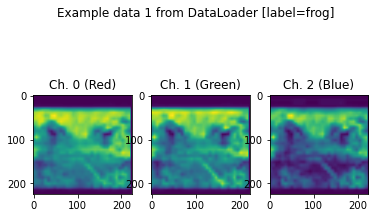

In [20]:
# Examine the data loader
train_enumerator = enumerate(train_loader)
ex_batch_idx, (ex_data, ex_label) = next(train_enumerator)
print(f'Idx: {ex_batch_idx} / X.shape = {ex_data.shape} / Y.shape = {ex_label.shape}\n')
print(f'Y[0:{batch_size}] = {ex_label.tolist()}')
print(f'→ Label = {np.array(test_data.classes)[ex_label]}\n')

preview_index = 1
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle(f'Example data {preview_index} from DataLoader [label={test_data.classes[ex_label[preview_index]]}]')
ax1.imshow(ex_data[preview_index, 0, :, :])
ax1.set_title('Ch. 0 (Red)')
ax2.imshow(ex_data[preview_index, 1, :, :])
ax2.set_title('Ch. 1 (Green)')
ax3.imshow(ex_data[preview_index, 2, :, :])
ax3.set_title('Ch. 2 (Blue)')
plt.show()

## 4. Function Definitions

Because our model is too simple now, we will use just `nn.Linear` module and wrap it with initializer function instead of defining a model class.

In [22]:
# Model
def init_model():
    global net, loss_fn, optim
    net = MyLittleCNN().to(device)
    loss_fn = nn.CrossEntropyLoss()
    optim = Adam(net.parameters(), lr=learning_rate)
  
  
class MyLittleCNN(nn.Module):
    """My Little Convolutional Neural Network for Active CAM, based on VGG11"""
  
    def __init__(self):
        super(MyLittleCNN, self).__init__()
        self.convolution_part = nn.Sequential(
            # channel, 필터개수, 필터크기
            nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.LeakyReLU(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.BatchNorm2d(256), nn.LeakyReLU(0.2),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.BatchNorm2d(256), nn.LeakyReLU(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1), nn.BatchNorm2d(512), nn.LeakyReLU(0.2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.BatchNorm2d(512), nn.LeakyReLU(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.BatchNorm2d(512), nn.LeakyReLU(0.2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.BatchNorm2d(512), nn.LeakyReLU(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.channelavg_part = nn.AvgPool2d(7)
        self.classifier_part = nn.Linear(512, 10, bias=False)
    
    def forward(self, data):
        conv_out = self.convolution_part(data)
        avg_out = self.channelavg_part(conv_out)
        avg_out_flatten = avg_out.reshape(avg_out.size(0), -1)
        classifier_out = self.classifier_part(avg_out_flatten)
        return classifier_out, conv_out

        
# Model structure check
Summary(MyLittleCNN().to(device), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
         LeakyReLU-3         [-1, 64, 224, 224]               0
         MaxPool2d-4         [-1, 64, 112, 112]               0
            Conv2d-5        [-1, 128, 112, 112]          73,856
       BatchNorm2d-6        [-1, 128, 112, 112]             256
         LeakyReLU-7        [-1, 128, 112, 112]               0
         MaxPool2d-8          [-1, 128, 56, 56]               0
            Conv2d-9          [-1, 256, 56, 56]         295,168
      BatchNorm2d-10          [-1, 256, 56, 56]             512
        LeakyReLU-11          [-1, 256, 56, 56]               0
           Conv2d-12          [-1, 256, 56, 56]         590,080
      BatchNorm2d-13          [-1, 256, 56, 56]             512
        LeakyReLU-14          [-1, 256,

In [26]:
# Epoch (similar to day 2)
def init_epoch():
    global epoch_cnt
    epoch_cnt = 0


def epoch(data_loader):
    # One epoch : gets data_loader as input and returns loss / accuracy, and
    #             last prediction value / its label(truth) value for future use
    global epoch_cnt
    iter_loss, iter_acc = [], []

    last_grad_performed = False

    # Mini-batch iterations
    for _data, _label in data_loader:
        data, label = _data.to(device), _label.to(device)

        # 1. Feed-forward
        onehot_out, _ = net(data)

        # 2. Calculate accuracy
        _, out = torch.max(onehot_out, 1)
        acc_partial = (out == label).float().sum()
        acc_partial = acc_partial / len(label)
        iter_acc.append(acc_partial.item())

        # 3. Calculate loss
        loss = loss_fn(onehot_out, label)
        iter_loss.append(loss.item())

        # 4. Backward propagation if not in `torch.no_grad()`
        if onehot_out.requires_grad:
            optim.zero_grad()
            loss.backward()
            optim.step()
            last_grad_performed = True

    # Up epoch count if backward propagation is done
    if last_grad_performed:
        epoch_cnt += 1

    # Clear memory to prevent CUDA memory error
    clear_memory()

    return np.average(iter_loss), np.average(iter_acc)


def epoch_not_finished():
    # For now, let's repeat training fixed times, e.g. 25 times.
    # We will learn how to determine training stop or continue later.
    return epoch_cnt < maximum_epoch

In [27]:
# Logging (same with day 2)
def init_log():
    global log_stack, iter_log, tloss_log, tacc_log, vloss_log, vacc_log, time_log
    iter_log, tloss_log, tacc_log, vloss_log, vacc_log = [], [], [], [], []
    time_log, log_stack = [], []
  
  
def record_train_log(_tloss, _tacc, _time):
    # Push time, training loss, training accuracy, and epoch count into lists
    time_log.append(_time)
    tloss_log.append(_tloss)
    tacc_log.append(_tacc)
    iter_log.append(epoch_cnt)
  
  
def record_valid_log(_vloss, _vacc):
    # Push validation loss and validation accuracy into each list
    vloss_log.append(_vloss)
    vacc_log.append(_vacc)

    
def last(log_list):
    # Get the last member of list. If empty, return -1.
    if len(log_list) > 0: return log_list[len(log_list) - 1]
    else: return -1
  
  
def print_log():
    # Generate log string and put it into log stack
    log_str = f'Iter: {last(iter_log):>4d} >> T_loss {last(tloss_log):<8.5f}   ' \
          + f'T_acc {last(tacc_log):<6.5f}   V_loss {last(vloss_log):<8.5f}   ' \
          + f'V_acc {last(vacc_log):<6.5f}   🕒 {last(time_log):5.3f}s'
    log_stack.append(log_str)
  
    # Draw figure if want
    if logging_dispfig:
        hist_fig, loss_axis = plt.subplots(figsize=(10, 3), dpi=99)
        hist_fig.patch.set_facecolor('white')

        # Draw loss lines
        loss_t_line = plt.plot(iter_log, tloss_log, label='Train Loss', color='#FF9999', marker='o')
        loss_v_line = plt.plot(iter_log, vloss_log, label='Valid Loss', color='#99B0FF', marker='s')
        loss_axis.set_xlabel('epoch')
        loss_axis.set_ylabel('loss')

        # Draw accuracy lines
        acc_axis = loss_axis.twinx()
        acc_t_line = acc_axis.plot(iter_log, tacc_log, label='Train Acc.', color='#FF0000', marker='+')
        acc_v_line = acc_axis.plot(iter_log, vacc_log, label='Valid Acc.', color='#003AFF', marker='x')
        acc_axis.set_ylabel('accuracy')

        # Append annotations
        hist_lines = loss_t_line + loss_v_line + acc_t_line + acc_v_line
        loss_axis.legend(hist_lines, [l.get_label() for l in hist_lines])
        loss_axis.grid()
        plt.title(f'Learning history until epoch {last(iter_log)}')
        plt.draw()
    
    # Print log
    clear_output(wait=True)
    if logging_dispfig: plt.show()
    for idx in reversed(range(len(log_stack))):
        print(log_stack[idx])

## 5. Training Iteration

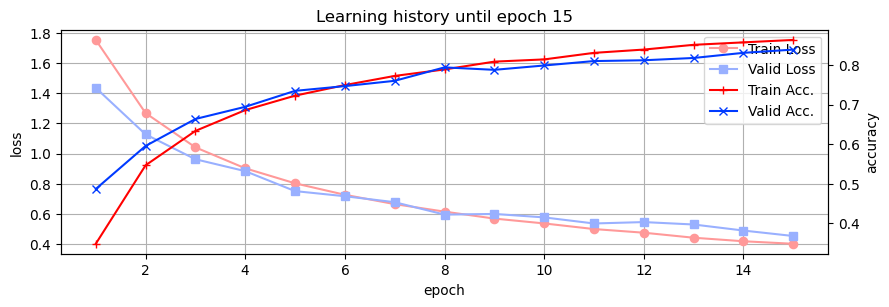

Iter:   15 >> T_loss 0.39983    T_acc 0.86329   V_loss 0.45153    V_acc 0.83886   🕒 200.330s
Iter:   14 >> T_loss 0.41660    T_acc 0.85713   V_loss 0.48783    V_acc 0.83067   🕒 200.209s
Iter:   13 >> T_loss 0.44012    T_acc 0.85093   V_loss 0.52807    V_acc 0.81769   🕒 200.275s
Iter:   12 >> T_loss 0.47349    T_acc 0.83895   V_loss 0.54418    V_acc 0.81190   🕒 200.302s
Iter:   11 >> T_loss 0.49778    T_acc 0.83061   V_loss 0.53486    V_acc 0.80990   🕒 200.269s
Iter:   10 >> T_loss 0.53516    T_acc 0.81408   V_loss 0.57531    V_acc 0.79872   🕒 200.260s
Iter:    9 >> T_loss 0.56744    T_acc 0.80845   V_loss 0.59831    V_acc 0.78774   🕒 200.279s
Iter:    8 >> T_loss 0.61367    T_acc 0.78870   V_loss 0.59401    V_acc 0.79393   🕒 200.256s
Iter:    7 >> T_loss 0.66357    T_acc 0.77234   V_loss 0.67639    V_acc 0.75998   🕒 200.246s
Iter:    6 >> T_loss 0.72562    T_acc 0.74922   V_loss 0.71607    V_acc 0.74661   🕒 200.409s
Iter:    5 >> T_loss 0.80194    T_acc 0.72248   V_loss 0.75016    V_ac

In [28]:
# Training Initialization (same with day 2)
init_model()
init_epoch()
init_log()

# Training Iteration (similar to day 2)
while epoch_not_finished():
    start_time = time.time()
    tloss, tacc = epoch(train_loader)
    end_time = time.time()
    time_taken = end_time - start_time
    record_train_log(tloss, tacc, time_taken)
    with torch.no_grad():
        vloss, vacc = epoch(valid_loader)
        record_valid_log(vloss, vacc)
    print_log()
    
print('\n Training completed!')

## 6. Result Analysis

In this section, we will calculate accuracy and confusion matrix for test dataset.

### 6.A Accuracy

In [29]:
# Accuracy for test dataset (similar to day 2)
with torch.no_grad():
    test_loss, test_acc = epoch(test_loader)
    print(f'Test accuracy = {test_acc}\nTest loss = {test_loss}')

Test accuracy = 0.8385
Test loss = 0.46619632272720335


### 6.B Class Activiation Map (CAM)

In [31]:
# Data preparation (load test data again, but without data augmentation)
cam_data_iterable = CIFAR10(root='./', train=False, download=False)
cam_data = list(cam_data_iterable)

Failed to find proper data for frog[6].
Failed to find proper data for ship[8].


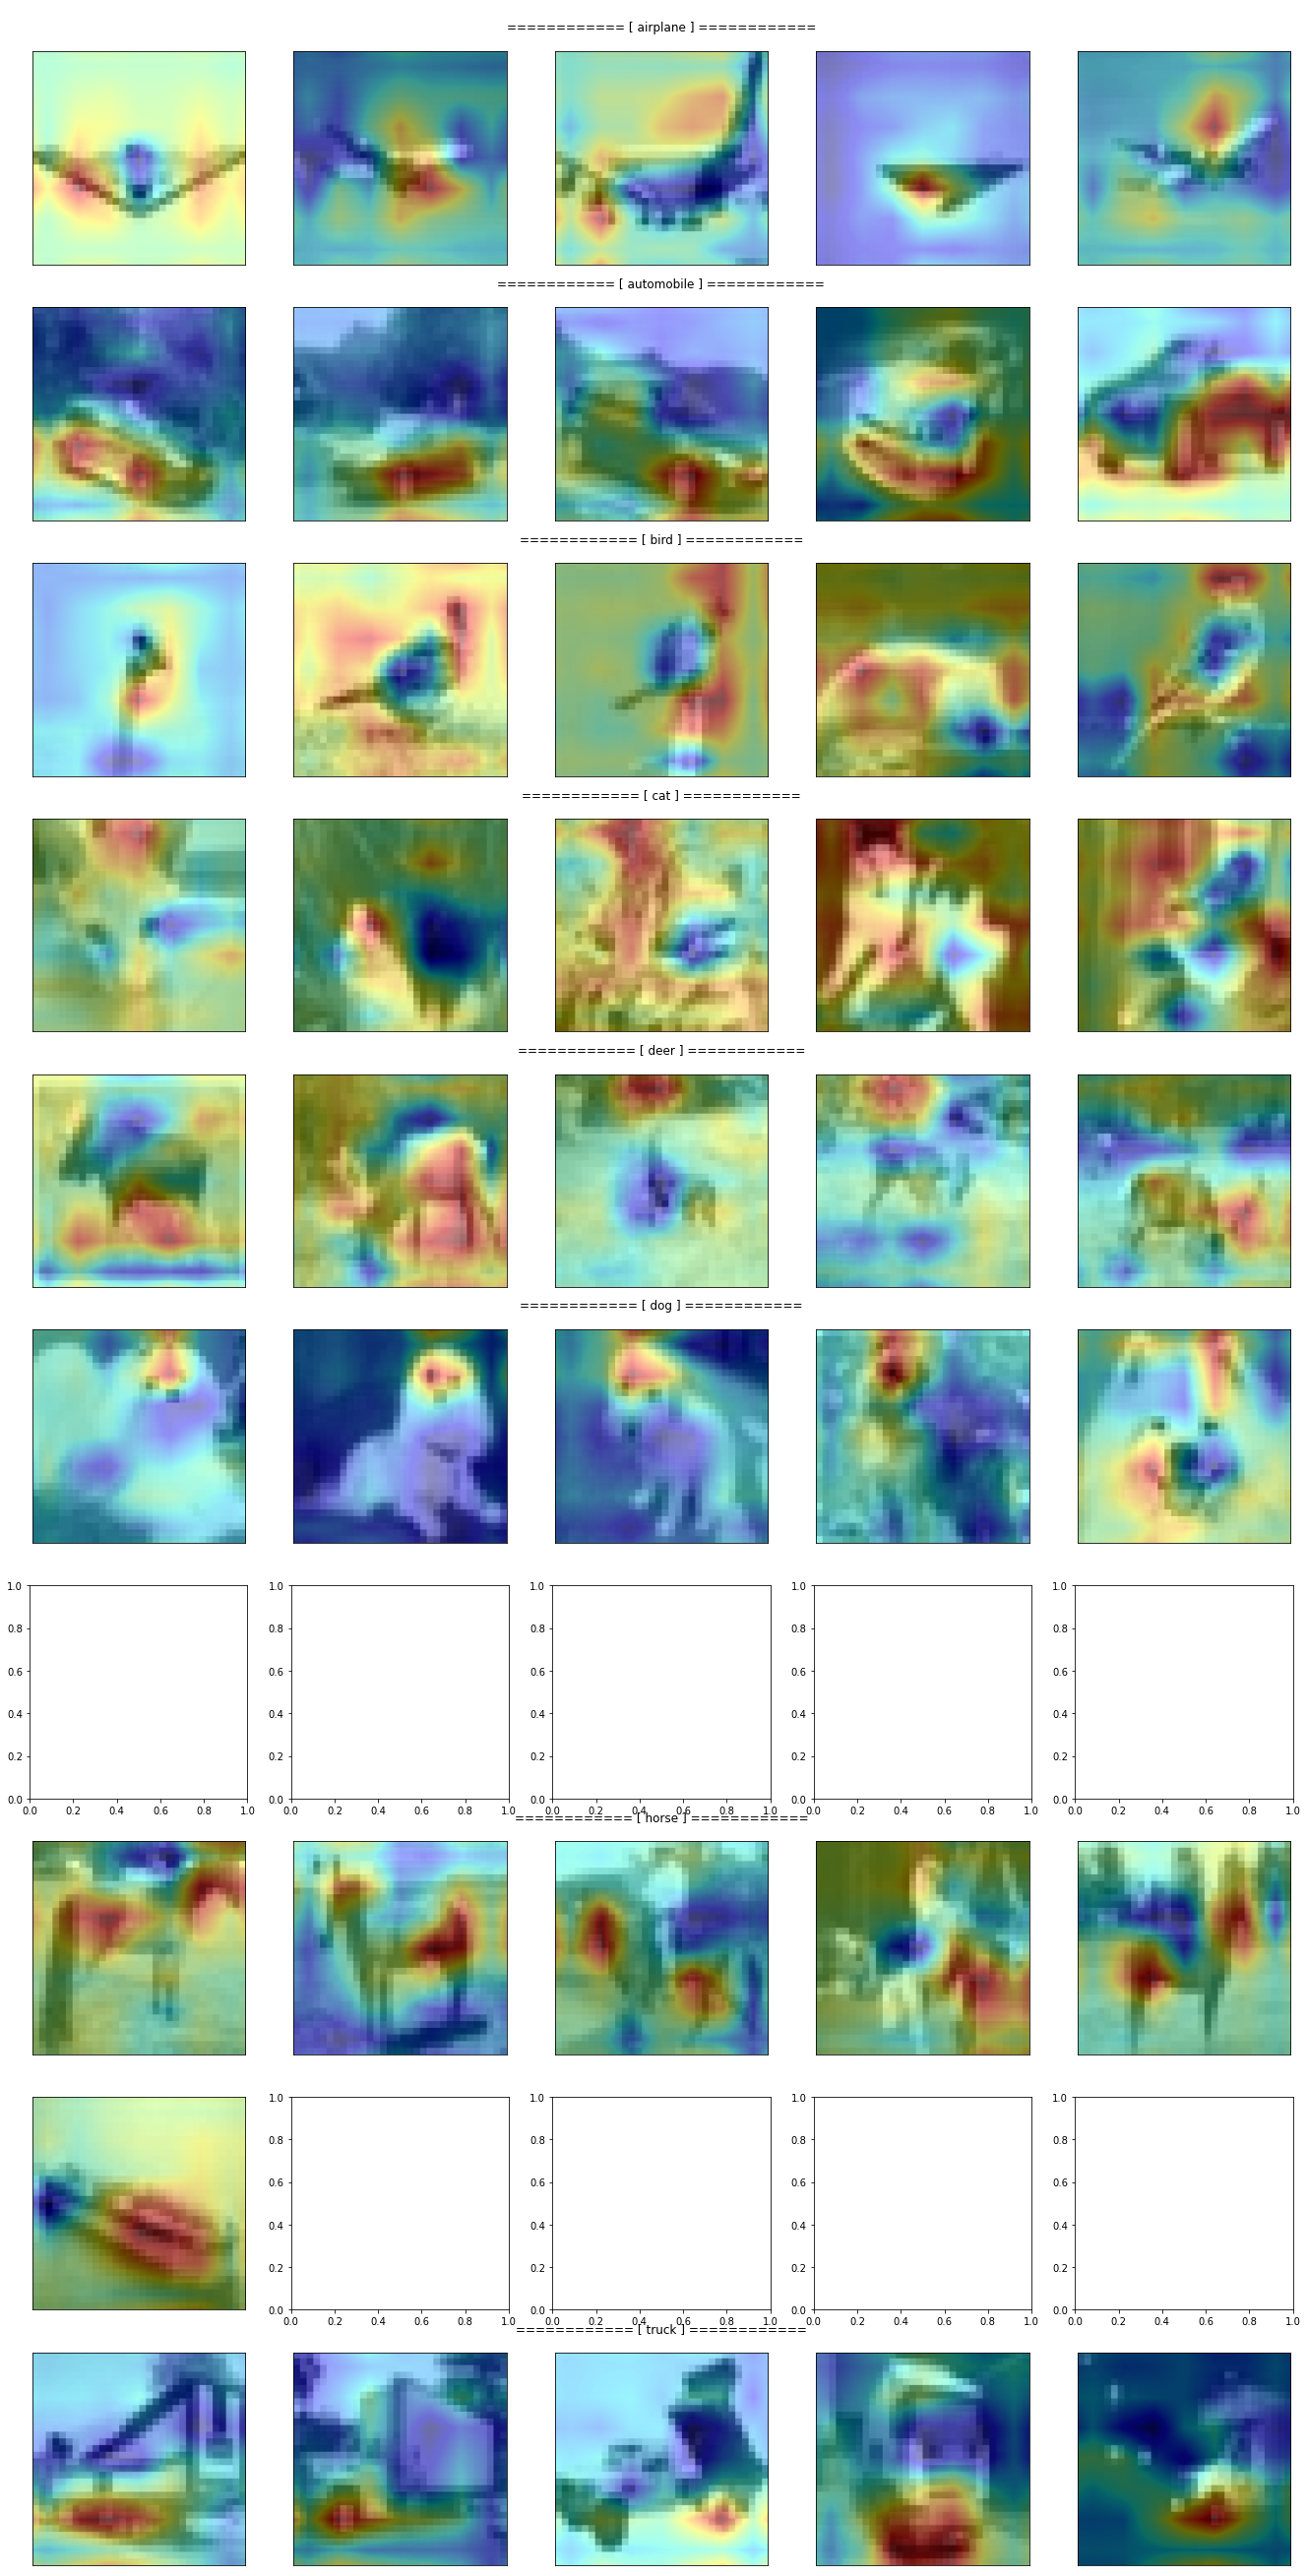

In [40]:
# Draw CAMs
cam_figidx = 1
cam_random_order = np.arange(len(cam_data), dtype=int)
np.random.shuffle(cam_random_order)

fig = plt.figure(figsize=(23, 47))
for class_idx, class_label in enumerate(cam_data_iterable.classes):
    # We will draw 5 CAMs for eatch classes
    class_axes = [
       fig.add_subplot(10, 5, cam_figidx),
       fig.add_subplot(10, 5, cam_figidx + 1),
       fig.add_subplot(10, 5, cam_figidx + 2),
       fig.add_subplot(10, 5, cam_figidx + 3),
       fig.add_subplot(10, 5, cam_figidx + 4),
    ]
    cam_figidx = cam_figidx + 5
   
   # Find 5 proper data with a specified "label"
    class_figidx = 0
    for random_order in cam_random_order:
        data, label = cam_data[random_order]
        if label == class_idx:
            # 1. Preprocess original image to put it into the model
            temp_input = ToTensor()(Resize(224)(data))
            temp_input = Normalize(mean=input_norm_mean, std = input_norm_std)(temp_input)
            temp_input = temp_input.reshape((1, 3, 224, 224)).to(device)

            # 2. Put the data into model and get convolutional part output and classifier output
            with torch.no_grad():
                temp_classifier_out, temp_conv_out = net(temp_input)
            _, temp_predicted_class = torch.max(temp_classifier_out, 1)

            # 3. If the predicted label is same with the truth, draw CAM of it
            if temp_predicted_class == label:
                conv_class_weight = list(net.parameters())[-1].squeeze()[label]
                temp_conv_out = temp_conv_out.reshape(512, 49)
                cam = conv_class_weight.matmul(temp_conv_out).reshape(7, 7).cpu().data.numpy()
                cam = cam - np.min(cam)
                cam = cam / np.max(cam)
                class_axes[class_figidx].imshow(
                    Grayscale()(Resize((512, 512), interpolation=0)(data)),
                    cmap='gray'
                )
                class_axes[class_figidx].imshow(OVResize(cam, [512,512]), cmap='jet', alpha=0.4)
                class_axes[class_figidx].set_xticks([], minor=False)
                class_axes[class_figidx].set_yticks([], minor=False)
                if class_figidx == 2:
                    class_axes[class_figidx].set_title(f'\n============ [ {class_label} ] ============\n')
                class_figidx = class_figidx + 1
                if class_figidx >= 5:
                    break
           
    # Tiny error message
    if class_figidx != 5:
        print(f'Failed to find proper data for {class_label}[{class_idx}].')
        
plt.show()

## 7. Saving Model

Are you satisfied with your model? Then save it!

In [36]:
torch.save(net, './model.pkl')

If you want to load your model, enter below.

In [37]:
net = torch.load('./model.pkl')